In [4]:
# 自动计算cell的计算时间
%load_ext autotime

%matplotlib inline
%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 435 ms (started: 2021-08-21 15:07:22 +08:00)


In [6]:
%%bash

# 增加更新
git add *.ipynb *.md

git remote -v

git commit -m '更新 #1  Aug 21, 2021'

git push origin master

origin	git@github.com:ustchope/eat_tensorflow2_in_30_days.git (fetch)
origin	git@github.com:ustchope/eat_tensorflow2_in_30_days.git (push)
[master 5d5cdc5] 更新 #1  Aug 21, 2021
 1 file changed, 102 insertions(+)
 create mode 100644 "\344\275\277\347\224\250\345\206\205\347\275\256\346\226\271\346\263\225\350\277\233\350\241\214\350\256\255\347\273\203\345\222\214\350\257\204\344\274\260.ipynb"


To git@github.com:ustchope/eat_tensorflow2_in_30_days.git
   bba3300..5d5cdc5  master -> master


time: 9.59 s (started: 2021-08-21 15:08:07 +08:00)


In [ ]:
#设置使用的gpu
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU")

# 设置

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

time: 786 µs (started: 2021-08-21 15:13:33 +08:00)


# 简介

本指南涵盖使用内置 API 进行训练和验证（例如 `Model.fit()`、`Model.evaluate()` 和 `Model.predict()`）时的训练、评估和预测（推理）模型。

如果您对在指定自己的训练步骤函数时利用 `fit()` 感兴趣，请参阅自定义 `fit()` 指南。

如果您有兴趣从头开始编写自己的训练和评估循环，请参阅“从头开始编写训练循环”指南。

一般来说，无论您是使用内置循环还是编写自己的循环，模型训练和评估在每种 Keras 模型中都严格按照相同的方式进行——顺序模型、使用功能 API 构建的模型以及通过以下方式从头开始编写的模型 模型子类化。

本指南不包括分布式训练，这在我们的多 GPU 和分布式训练指南中有所介绍。

# API 概述：第一个端到端示例

将数据传递给模型的内置训练循环时，您应该使用 NumPy 数组（如果您的数据很小并且适合内存）或 tf.data 数据集对象。 在接下来的几段中，我们将使用 MNIST 数据集作为 NumPy 数组，以演示如何使用优化器、损失和指标。

让我们考虑以下模型（在这里，我们使用 Functional API 构建，但它也可以是 Sequential 模型或子类模型）：

In [7]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

time: 11.4 s (started: 2021-08-21 15:10:52 +08:00)


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
predictions (Dense)          (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
time: 4.22 ms (started: 2021-08-21 15:11:08 +08:00)


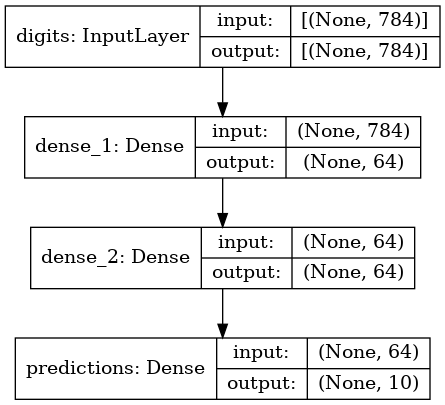

time: 6.93 s (started: 2021-08-21 15:13:47 +08:00)


In [10]:
plot_model(model, show_shapes=True)

以下是典型的端到端工作流程，包括：
* 训练
* 对从原始训练数据生成的保留集进行验证
* 对测试数据的评估

我们将在此示例中使用 MNIST 数据。

In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

time: 740 ms (started: 2021-08-21 15:15:12 +08:00)


我们指定训练配置（优化器、损失、指标）：

In [12]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

time: 29.2 ms (started: 2021-08-21 15:16:32 +08:00)


我们调用 fit()，它将通过将数据切成大小为 batch_size 的“批次”来训练模型，并在给定数量的 epoch 中重复迭代整个数据集。

In [13]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data
Epoch 1/2
782/782 [==============================] - 9s 9ms/step - loss: 0.3438 - sparse_categorical_accuracy: 0.8999 - val_loss: 0.1989 - val_sparse_categorical_accuracy: 0.9423
Epoch 2/2
782/782 [==============================] - 7s 9ms/step - loss: 0.1590 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.1447 - val_sparse_categorical_accuracy: 0.9597
time: 17.4 s (started: 2021-08-21 15:17:13 +08:00)


返回的历史对象保存了训练期间损失值和度量值的记录：

In [14]:
history.history

{'loss': [0.3438098728656769, 0.15895701944828033],
 'sparse_categorical_accuracy': [0.899940013885498, 0.9521600008010864],
 'val_loss': [0.1989143341779709, 0.1446656733751297],
 'val_sparse_categorical_accuracy': [0.942300021648407, 0.9596999883651733]}

time: 4.48 ms (started: 2021-08-21 15:18:21 +08:00)


In [17]:
import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

time: 1.81 ms (started: 2021-08-21 15:20:36 +08:00)


In [16]:
plot_metric(history,"loss")

NameError: name 'plt' is not defined

time: 196 ms (started: 2021-08-21 15:20:10 +08:00)
